In [1]:
import os,sys,time,math
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, SparsePCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from scipy.stats import pearsonr
from scipy import signal

## Preprocessing

In [3]:
# Read data
wd = '/Users/meini/data/tfMRI_roi_mean/AAL90/LANGUAGE'
filelist = [f for f in os.listdir(wd) if 'csv' in f]
data = []
nload = 100
for i in range(nload):
    fpath = wd+'/'+filelist[i]
    data.append(np.genfromtxt(fpath, delimiter=',').T)

data = np.asarray(data) # nsub, ntime, nroi
data = np.moveaxis(data,[0,2],[2,0]) # nroi x ntime x nsub
print(data.shape)
nroi,ntime,nsub = data.shape

(90, 316, 100)


In [3]:
plt.figure()
for r in range(nroi):
    plt.plot(data[0,:,r])

Hemodynamic response is removed. Then we just need to regress out the linear trend or even quadratic $(1,t,t^2)$ estimated by least square.

In [8]:
# regress out the deterministic trend by voxelwise regression
def detrend(data):
    '''
    Remove constant mean, linear trend and quadratic trend 
    in a voxelwise manner.
    '''
    nsub, ntime, nroi = data.shape
    X = np.vstack([np.asarray([t+1 for t in range(ntime)]), 
                   np.square(np.asarray([t+1 for t in range(ntime)]))]).T
    X[:,0] = X[:,0] - np.mean(X[:,0])
    X[:,1] = X[:,1] - np.mean(X[:,1])
    for s in range(nsub):
        for r in range(nroi):
            Y = data[s,:,r]
            model = LinearRegression(fit_intercept=True,
                                     normalize=False).fit(X,Y)
            data[s,:,r] = Y - model.predict(X)
    
    return data

In [9]:
data = detrend(data)

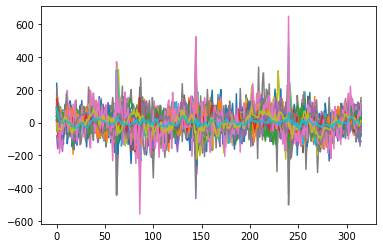

In [10]:
plt.figure()
for r in range(nroi):
    plt.plot(data[0,:,r])

(array([-200, -199, -198, -197, -196, -195, -194, -193, -192, -191, -190,
        -189, -188, -187, -186, -185, -184, -183, -182, -181, -180, -179,
        -178, -177, -176, -175, -174, -173, -172, -171, -170, -169, -168,
        -167, -166, -165, -164, -163, -162, -161, -160, -159, -158, -157,
        -156, -155, -154, -153, -152, -151, -150, -149, -148, -147, -146,
        -145, -144, -143, -142, -141, -140, -139, -138, -137, -136, -135,
        -134, -133, -132, -131, -130, -129, -128, -127, -126, -125, -124,
        -123, -122, -121, -120, -119, -118, -117, -116, -115, -114, -113,
        -112, -111, -110, -109, -108, -107, -106, -105, -104, -103, -102,
        -101, -100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,
         -90,  -89,  -88,  -87,  -86,  -85,  -84,  -83,  -82,  -81,  -80,
         -79,  -78,  -77,  -76,  -75,  -74,  -73,  -72,  -71,  -70,  -69,
         -68,  -67,  -66,  -65,  -64,  -63,  -62,  -61,  -60,  -59,  -58,
         -57,  -56,  -55,  -54,  -53, 

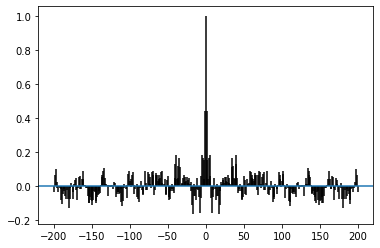

In [17]:
plt.acorr(data[0,:,0], maxlags=200)

## Analysis in the ROI Level

In [8]:
obs_mean = np.mean(data,axis=1)
print(obs_mean.shape)
print(obs_mean.min())
print(obs_mean.max())
plt.hist(obs_mean)

(90, 100)
-12.804258383856272
16.248763896013717


(array([[ 0.,  0.,  0.,  0., 79., 11.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 69., 21.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  3., 69., 18.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  5., 64., 21.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  2., 84.,  4.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 48., 42.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  8., 58., 22.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 84.,  6.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  3., 85.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 19., 70.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  3., 60., 25.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1., 80.,  9.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  3., 81.,  6.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 11., 78.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1., 71., 18.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 88.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  3., 76., 11.,  

(90, 100)
147.22456680020366
118961.53572913646


(array([[89.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [90.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [90.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [89.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [89.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [90.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [83.,  5.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [89.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [90.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [90.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [88.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [83.,  4.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
        [89.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [90.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [90.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [90.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [89.,  1.,  0.,  0.,  0.,  0.,  

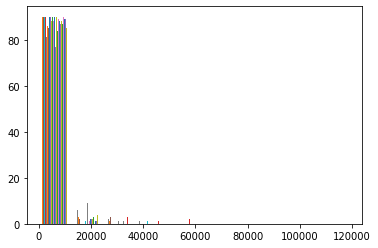

In [9]:
obs_var = np.var(data,axis=1)
print(obs_var.shape)
print(obs_var.min())
print(obs_var.max())
plt.hist(obs_var)

In [4]:
# Test for the existence of unit roots
def find_integration_order(data, pval_bound=0.05):
    if type(data)==np.ndarray:
        data = data.tolist()
        for s in range(len(data)):
            data[s] = np.asarray(data[s])
    
    assert(type(data)==list)
    nsub = len(data)
    ords = []
    for s in range(nsub):
        ntime = data[s].shape[0]
        nroi = data[s].shape[1]
        tmp = np.zeros((nroi))
        for r in range(nroi):
            pval = 1
            ndiff = -1
            while pval >= pval_bound:
                ndiff = ndiff + 1
                pval = adfuller(np.diff(data[s][:,r], n=ndiff))[1]
                # adfuller
                # null hypothesis: there is a unit root (pval(0.3) >= pval_bound(0.05))
                # alternative: there is no unit root (pval(0.001) < pval_bound(0.05))

            tmp[r] = ndiff
        
        ords.append(tmp)
    
    return ords

In [11]:
ords = np.asarray(find_integration_order(data))
print(ords.shape)

(100, 90)


1.0


Text(0.5, 1.0, 'Histogram of Number of I(1) integrated ROIs')

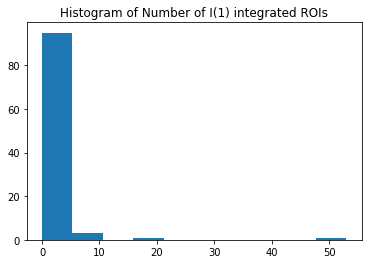

In [12]:
print(np.max(ords.flatten()))
plt.hist(np.sum(ords,axis=1))
plt.title("Histogram of Number of I(1) integrated ROIs")

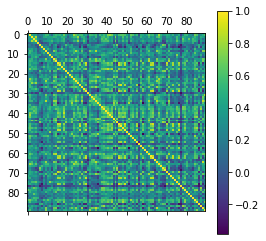

In [15]:
plt.matshow(pd.DataFrame(data[0,:,:]).corr())
plt.colorbar()

## Analysis in the Factor Level

$$
\begin{aligned}
& Y_t = Uf_t \Rightarrow f_t = U'Y_t.
& Y = FU' \Rightarrow F = YU
\end{aligned}
$$

In [37]:
def pca_everything(data):
    nsub = data.shape[0]
    pca = PCA(n_components=5, svd_solver = 'full', whiten=False)
    f_all = []
    U_all = []
    epsilon_all = []
    ncomp = []
    for s in range(nsub):
        Y_all = data[s,:,:].squeeze() # ntime x nroi
        pca_all = pca.fit(Y_all); 
        U_all.append(pca_all.components_.T) # nroi x nfactor
        f_all.append(Y_all @ U_all[s]) # f_all: ntime x nfactor
        ncomp.append(pca_all.n_components_)
        epsilon_all.append(Y_all - f_all[s] @ U_all[s].T)

    return f_all, U_all, epsilon_all, ncomp

In [38]:
f_all, U_all, epsilon_all, ncomp = pca_everything(data)

It shows that there are some factors are nonstationary (factor 1, 3 and 4) and cointegrated (factor 2 and factor 3), which can be further confirmed using the following tests.

In [40]:
# The integration orders are printed.
ords = np.asarray(find_integration_order(f_all))
ords.shape

(100, 5)

1.0


Text(0.5, 1.0, 'Histogram of Number of I(1) integrated Factors')

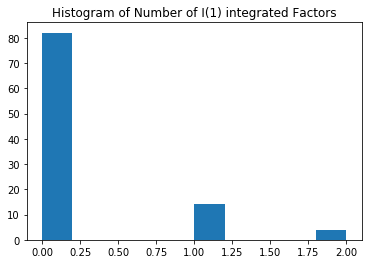

In [43]:
print(np.max(ords.flatten()))
plt.hist(np.sum(ords,axis=1))
plt.title("Histogram of Number of I(1) integrated Factors")

But note that this estimation of dynamic factors are not reliable because neither the original time series nor the factor time series is stationary.

In [44]:
ords = np.asarray(find_integration_order(epsilon_all))
ords.shape

(100, 90)

1.0


Text(0.5, 1.0, 'Histogram of Number of I(1) integrated Errors')

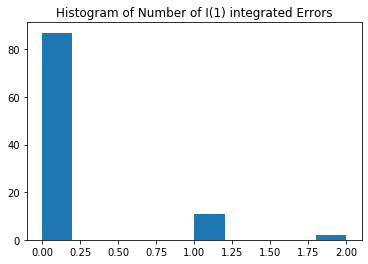

In [45]:
print(np.max(ords.flatten()))
plt.hist(np.sum(ords,axis=1))
plt.title("Histogram of Number of I(1) integrated Errors")

The error terms are all integrated of order 1. This makes it suitable to use the I(1) dynamic factor model.

## Analysis of the differenced data

In [46]:
data_diff = np.diff(data, n=1, axis=1)
data_diff.shape

(100, 315, 90)

In [47]:
ords = np.asarray(find_integration_order(data_diff))
print(np.max(ords.flatten()))
plt.hist(np.sum(ords,axis=1))
plt.title("Histogram of Number of I(1) integrated Diff Series")

0.0


Text(0.5, 1.0, 'Histogram of Number of I(1) integrated Diff Series')

First order difference makes everything nicer.